In [1]:
import ebooklib
from ebooklib import epub
import re
import os

import enchant

import gensim
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words, stopwords, names

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

D:\DesignAPP\anaconda3\envs\demoEnvpy38\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\46981\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\46981\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import numpy as np
from scipy.sparse import random
from sklearn.decomposition import TruncatedSVD

In [3]:
import matplotlib.pyplot as plt

import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import random
import os
import numpy as np
from PIL import Image
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from IPython.display import Image as iImage
from IPython.display import display
import math

import pickle
import scipy
from matplotlib import cm

from sklearn.decomposition import PCA


# Extract paragraph

In [4]:
def merge_strings_until_limit(strings, min_length, max_length, test_for_max=0):
    merged_string = ""
    merged_strings = []

    for s in strings:
        if len(merged_string) <= min_length:
            merged_string += s
        elif len(merged_string) > max_length and test_for_max < 5:
            splitParagraph = merged_string.split('.')
            splitParagraphRePoint = []
            for sp in splitParagraph:
                splitParagraphRePoint.append(sp + '.')
            merged = merge_strings_until_limit(splitParagraphRePoint, min_length, max_length, test_for_max + 1)
            merged_strings.extend(merged)
            merged_string = s
        else:
            merged_strings.append(merged_string)
            merged_string = s

    if merged_string:
        merged_strings.append(merged_string)

    return merged_strings



In [5]:
def read_epub_paragraphs_from_folder(folder_path):
    all_paragraphs = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.epub'):
            file_path = os.path.join(folder_path, filename)
            paragraphs = read_epub_paragraphs(file_path)
            all_paragraphs.extend(paragraphs)

    return all_paragraphs

In [6]:
def read_epub_paragraphs(epub_file):
    book_id = os.path.basename(epub_file)  # Extract filename from path
    book = epub.read_epub(epub_file)
    paragraphs = []

    for item in book.get_items():
        if item.get_type() == epub.ebooklib.ITEM_DOCUMENT:
            content = item.get_content().decode('utf-8')
            content = re.sub('<[^<]+?>', '', content)  # Remove HTML tags
            content = re.sub('\s+', ' ', content)  # Replace multiple whitespaces with a single space
            content = re.sub('\n', ' ', content)
            paragraphs.extend(content.strip().split("&#13;"))

    paragraphs = merge_strings_until_limit(paragraphs, 200, 1000)
    paragraphs = [paragraphs[i] for i in range(len(paragraphs)) if len(paragraphs[i]) > 50]
    return paragraphs[1:-1]

In [7]:
# Example usage:
folder_path = "./book"
paragraphs = read_epub_paragraphs_from_folder(folder_path)

D:\DesignAPP\anaconda3\envs\demoEnvpy38\lib\site-packages\ebooklib\epub.py:1395: UserWarning: In the future version we will turn default option ignore_ncx to True.
  warnings.warn('In the future version we will turn default option ignore_ncx to True.')


In [8]:
len(paragraphs)

1092

In [9]:
paragraphs[100]

' She didn’t have anyone to send to college anyway. She did, however, have Esther, her best friend and a professor at the law school, who was kind enough to check up on the house once a week. It was basically on the way from Pasadena, where she lived with her husband and nine-year-old son. Esther had written the previous night to say that all was well and that she hoped Adrianna was finally “getting busy” as she put it.'

# Vectorise text

In [7]:
paragraphs = []

with open('results_list0223.txt', 'r', encoding='utf-8') as file:
    # 使用 readlines() 方法读取每一行文本并存储到列表中
    paragraphs = file.readlines()

print(len(paragraphs))

2500


In [8]:
processedDoc = paragraphs

In [9]:
processedDoc[0:5]

['square_01:  The lamplighter was just lighting the lamps in the square..\n',
 'square_02:  She can move across any number of squares, in any direction, imitating the movement of all the other pieces except for the knight. As we can see, the black queen could have come from four possible squares: a2, b2, b3 and d3.\n',
 'square_03:  Sporting Lisbon, 97 Square Posts Final, 248, 286 Steaua Bucharest, 272, 279, 281 Steilike, Uli, 256 Stoichkov, Hristo, 10, 278, 283, 290–291, 294, 296–298, 305–306, 311, 320, 385, 418 Strubell, Toni, 4, 30\n',
 'square_04:  Madrid : Midnight City, Reaktion Books, Limited, 2021. ProQuest Ebook Central, Squares The term ‘square’ is a misnomer when talking about Madrid’s traditional hubs of social interaction. Few, if any, fit this profile.\n',
 'square_05: " "Very good," said Munoz. "Why not?" "Because b3 is a white square. Anyway, if that bishop had moved diagonally along the black squares from b4, it would still be there on the board, and it isn\'t. I imagi

In [18]:
vectorizer = TfidfVectorizer(min_df=3)
tfidf_matrix = vectorizer.fit_transform(processedDoc)

n_components = 250  # Number of components to keep after reduction
svd = TruncatedSVD(n_components=n_components, algorithm='randomized')
reduced_matrix = svd.fit_transform(tfidf_matrix)

In [19]:
len(reduced_matrix)

2500

In [113]:
word_vectors_matrix = np.array(reduced_matrix)
pca = PCA(n_components=4)
pca_u_matrix = pca.fit_transform(word_vectors_matrix)

# SOM test

In [12]:
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p

def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p

In [13]:
# Return the (g,h) index of the BMU in the grid
def find_BMU(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argmax(cos_sims, axis=None), cos_sims.shape)

# Return the (g,h) index of the BMU in the grid
def find_BMU_2(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argpartition(cos_sims, -2, axis=None)[-2], cos_sims.shape)

def update_weights(SOM, train_ex, learn_rate, radius_sq, 
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])   
    return SOM    

# Main routine for training an SOM. It requires an initialized SOM grid
# or a partially trained grid as parameter
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1, 
             lr_decay = .1, radius_decay = .1, epochs = 10):    
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        rand.shuffle(train_data)      
        for train_ex in train_data:
            g, h = find_BMU(SOM, train_ex)
            SOM = update_weights(SOM, train_ex, 
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)            
    return SOM

In [14]:
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'cosine')[0][0]
    QE = sumSqDist/len(data)
    return QE

def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)

In [15]:
import sklearn

def cosine(a,b):
    return cosine_similarity([a], [b])[0][0]

def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)

    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += cosine(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += cosine(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values

In [16]:
def activate(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[cosine_similarity([normalP], [c])[0][0] for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    #activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM

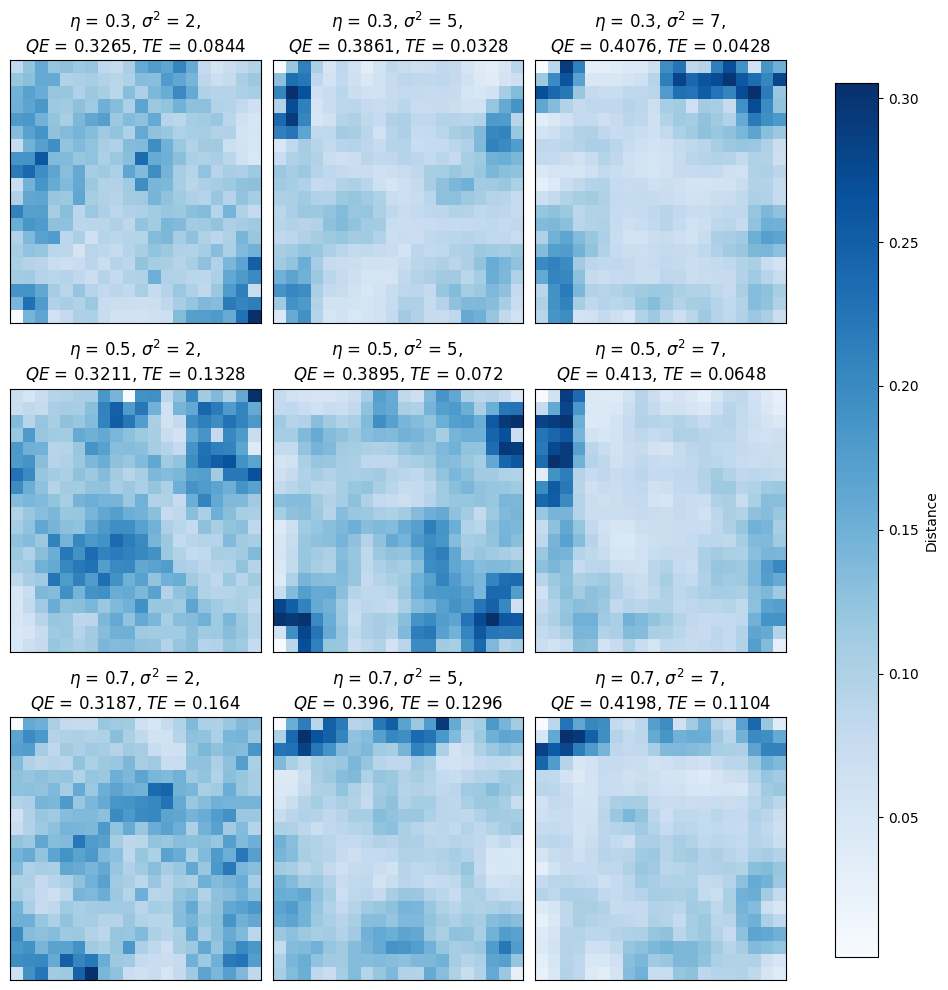

<Figure size 640x480 with 0 Axes>

In [68]:
SOMS = []
learn_rates = [0.3, 0.5, 0.7]
radiuses = [2, 5, 7]
m, n = 20, 20
vector_size = 250

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10), subplot_kw=dict(xticks=[], yticks=[]))
param_combinations = [(lr, rsq) for lr in learn_rates for rsq in radiuses]

for i, (learn_rate, radius_sq) in enumerate(param_combinations):
    rand = np.random.RandomState(0)
    SOM = rand.uniform(0, 1, (m, n, vector_size))
    SOM = train_SOM(SOM, reduced_matrix, epochs=20, learn_rate=learn_rate, radius_sq=radius_sq)
    SOMS.append(SOM)

    u_matrix_values = u_matrix(SOM)
    ax = axes[i // 3, i % 3]
    im = ax.imshow(u_matrix_values, cmap=cm.Blues, aspect='auto')
    QE = round(calculateQE(SOM, reduced_matrix), 4)
    TE = round(calculateTE(SOM, reduced_matrix), 4)
    ax.set_title('$\eta$ = ' + str(learn_rate) + 
                    ', $\sigma^2$ = ' + str(radius_sq) + 
                    ', \n$QE$ = ' + str(QE) + 
                    ', $TE$ = ' + str(TE))

plt.tight_layout()
cbar = plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
cbar.set_label('Distance')

plt.savefig('SOMs.png', dpi=300)
plt.show()

In [70]:
SOM= SOMS[1]

C:\Users\46981\AppData\Local\Temp\ipykernel_20048\183655475.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


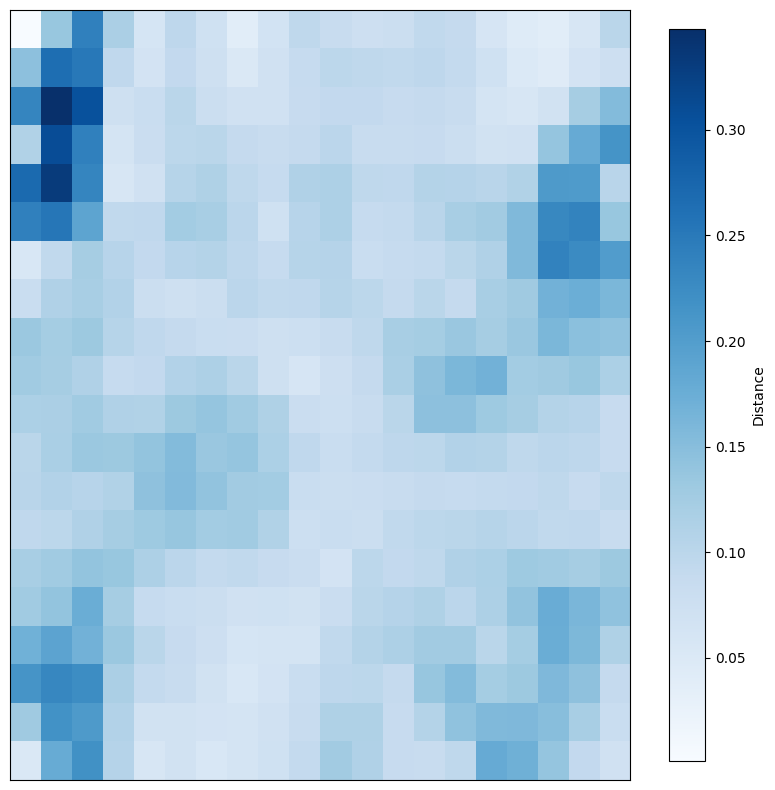

In [71]:
u_matrix_values = u_matrix(SOM)
QE = round(calculateQE(SOM, reduced_matrix), 4)
TE = round(calculateTE(SOM, reduced_matrix), 4)

plt.figure(figsize=(10, 10))
cmap = cm.get_cmap('Blues')
im = plt.imshow(u_matrix_values, cmap=cmap, aspect='auto')

plt.colorbar(im, shrink=0.95, label='Distance')
plt.xticks([])
plt.yticks([])
plt.show()
     

In [72]:
neuron_word_mapping = {}
for i in range(SOM.shape[0]):
    for j in range(SOM.shape[1]):
        neuron_word_mapping[(i, j)] = []

for word, vector in zip(paragraphs, reduced_matrix):
    best_matching_unit = find_BMU(SOM, vector)
    if best_matching_unit not in neuron_word_mapping:
        neuron_word_mapping[best_matching_unit] = []
    neuron_word_mapping[best_matching_unit].append(word)
     

C:\Users\46981\AppData\Local\Temp\ipykernel_20048\468106158.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


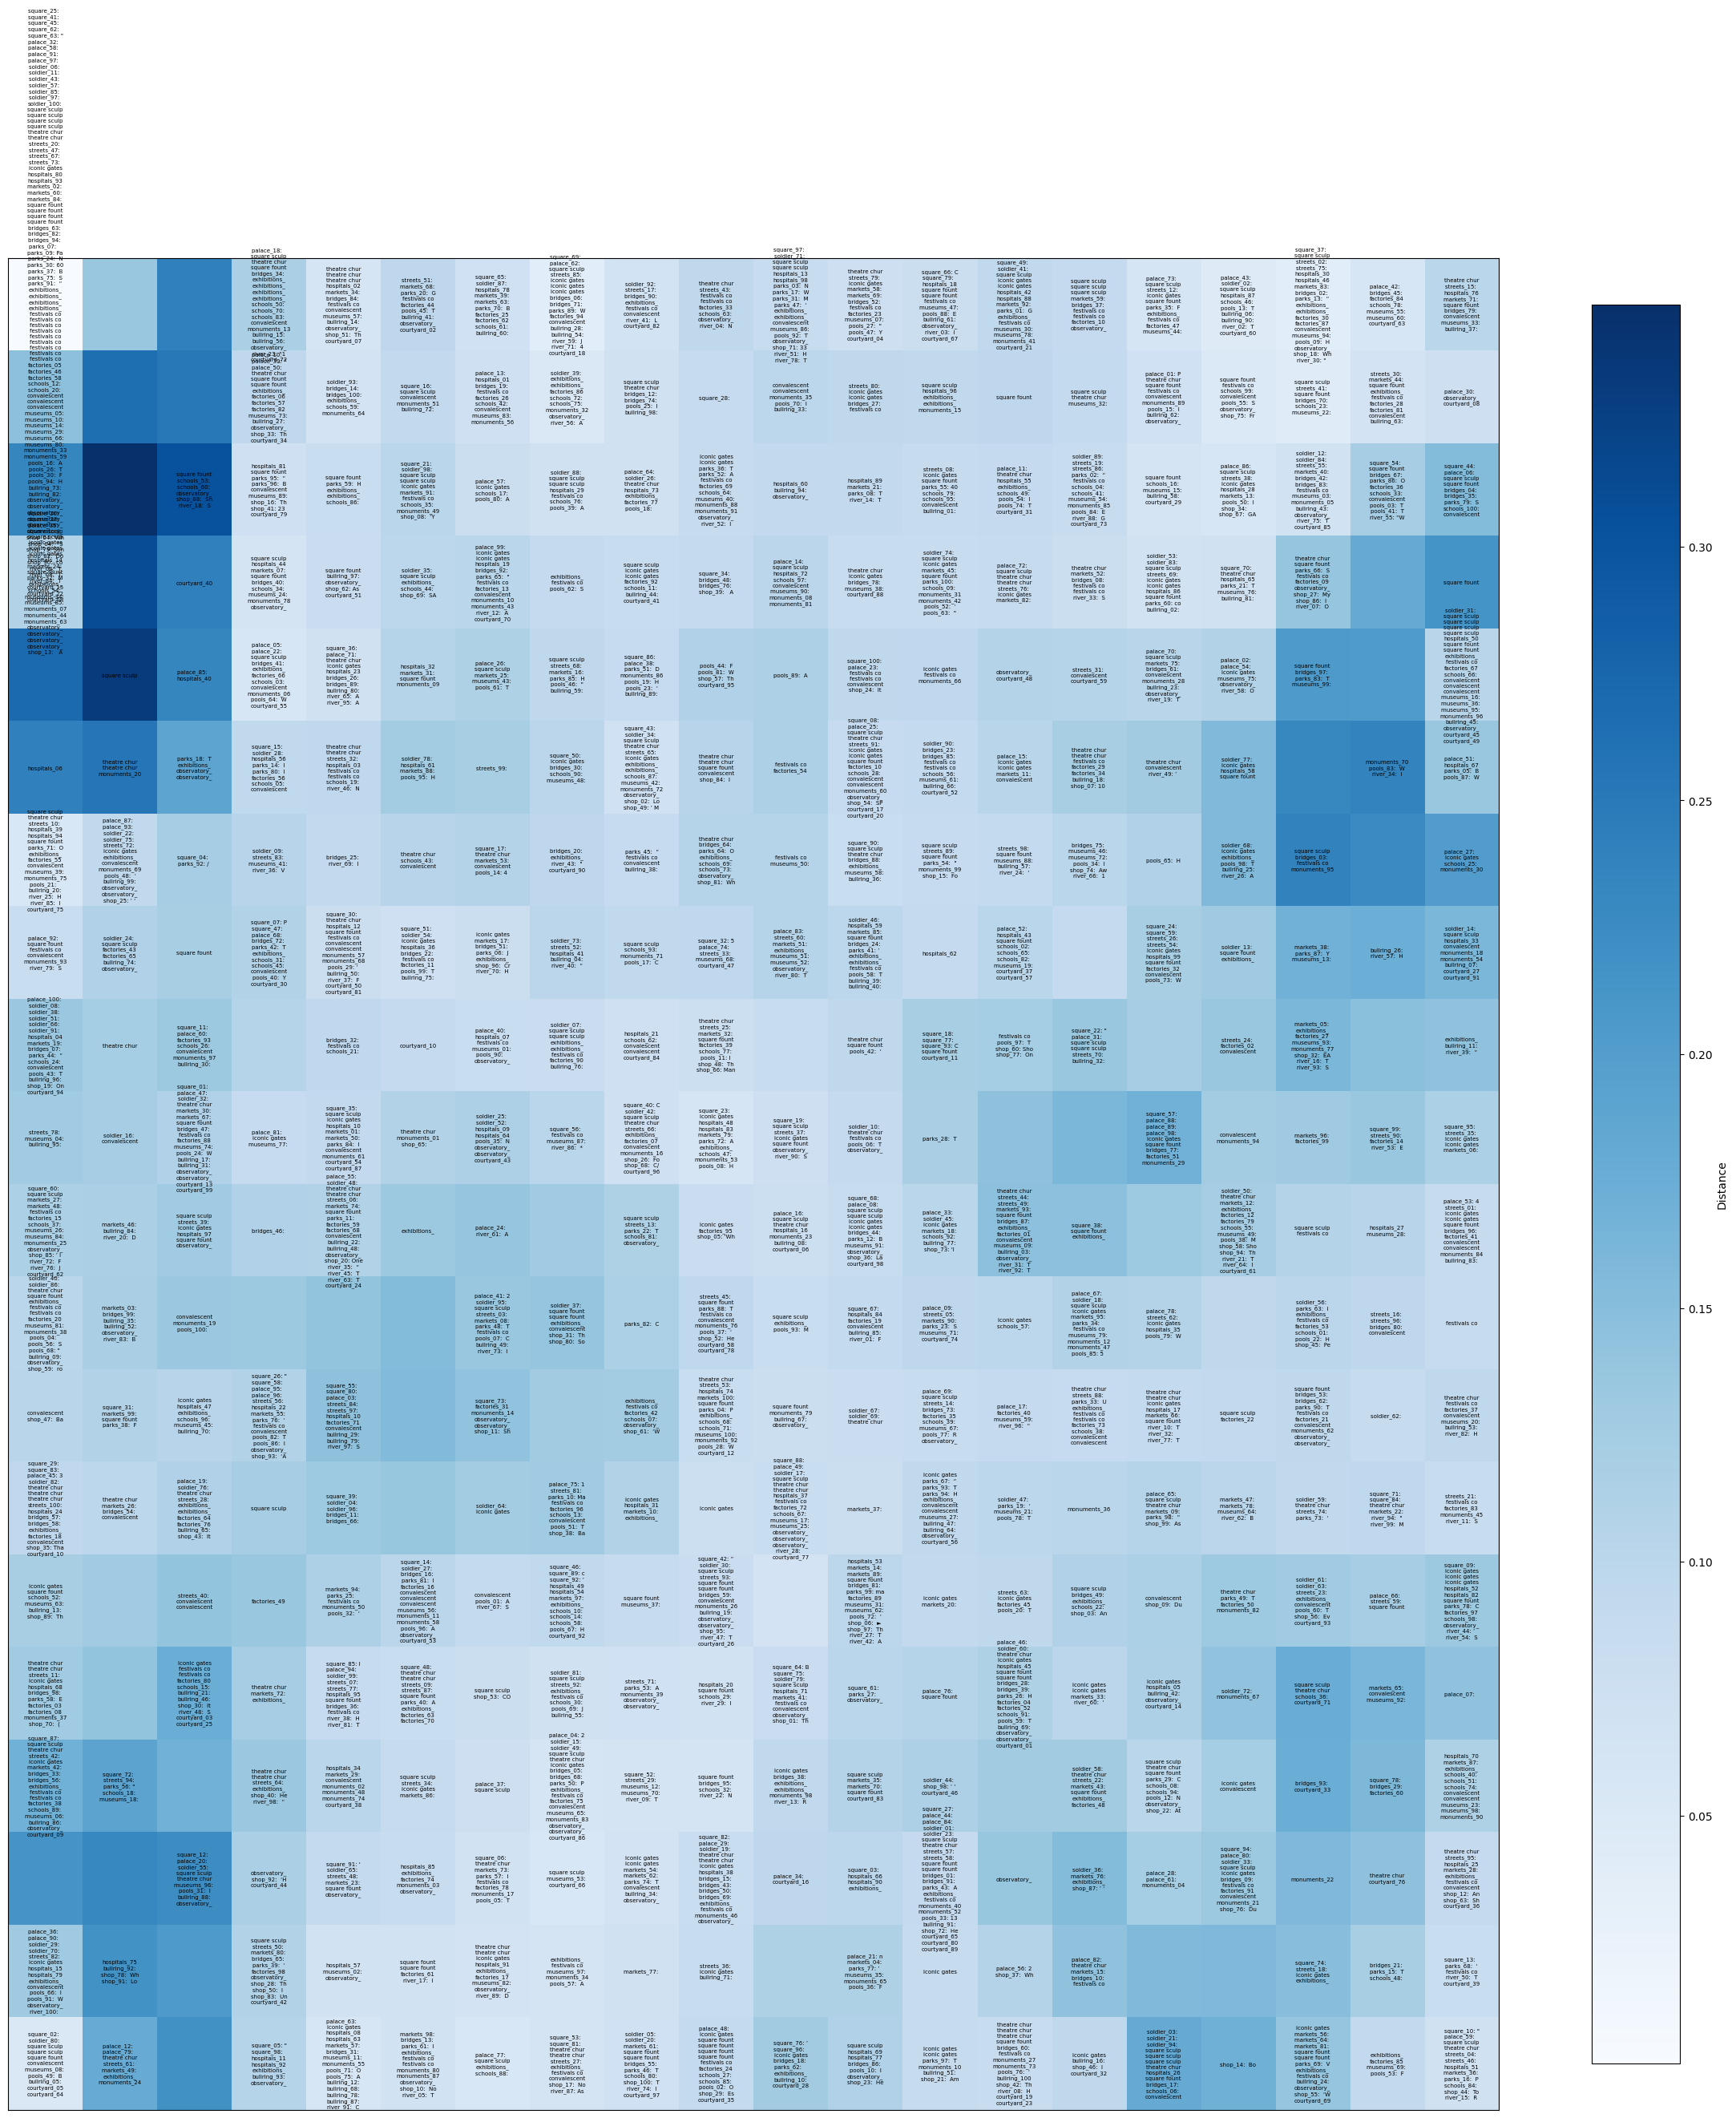

In [73]:
plt.figure(figsize=(30, 30))
cmap = cm.get_cmap('Blues')
im = plt.imshow(u_matrix_values, cmap=cmap, aspect='auto')
plt.colorbar(im, shrink=0.95, label='Distance')

for (i, j), words in neuron_word_mapping.items():
    # 仅显示每段文本的前几个字符
    truncated_text = [word[:12] for word in words]
    text = '\n'.join(truncated_text)
    plt.text(j, i, text, ha='center', va='center', color='black', fontsize=5)

plt.xticks([])
plt.yticks([])

# 保存图像到文件
plt.savefig('som_visualization.png', dpi=300)
plt.show()


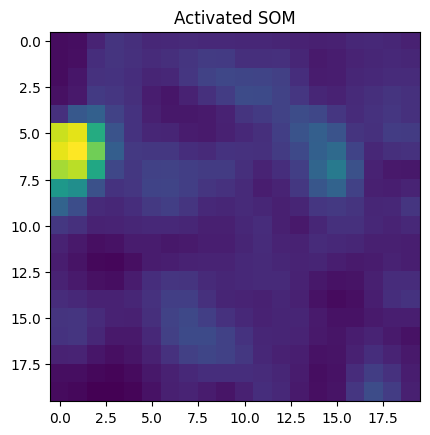

The SOM unit activated by the input words is located at coordinates: (6, 1)


In [75]:
def activate_SOM_with_words(input_words, SOM, vectorizer, svd):
    # Convert input words to a single string
    input_text = ' '.join(input_words)

    # Tokenize and vectorize the input text
    input_vector = vectorizer.transform([input_text])
    input_vector_reduced = svd.transform(input_vector)

    # Normalize input data
    normalized_input = normalise(u_matrix_values, input_vector_reduced[0])

    # Activate SOM with input data
    activated_SOM = activate(u_matrix_values, SOM, normalized_input)

    # Find the BMU (Best Matching Unit) for the input data
    bmu_coordinates = find_BMU(SOM, normalized_input)

    return activated_SOM, bmu_coordinates

# Example usage:
input_words = ["market","standing","enjoying","holding","talking","captures","walking","sitting","eating","drink","glimpse"]

# Activate SOM with input words
activated_SOM, bmu_coordinates = activate_SOM_with_words(input_words, SOM, vectorizer, svd)

# Visualize the activated SOM
plt.imshow(activated_SOM, cmap='viridis', interpolation='none')
plt.title('Activated SOM')
plt.show()

print(f'The SOM unit activated by the input words is located at coordinates: {bmu_coordinates}')


In [76]:
def get_paragraphs_for_coordinates(coordinates, SOM, paragraphs, m, n):
    g, h = coordinates
    
    # Convert 2D coordinates to 1D index
    unit_index = g * n + h
    
    # Print the unit index
    print(f'The one-dimensional index for the coordinates {coordinates} is: {unit_index}')
 


# Example usage:
input_coordinates = (6, 1)

# Get paragraphs for the specified coordinates
get_paragraphs_for_coordinates(input_coordinates, SOM, processedDoc, m, n)


The one-dimensional index for the coordinates (6, 1) is: 121


C:\Users\46981\AppData\Local\Temp\ipykernel_20048\927115223.py:29: UserWarning: Glyph 31070 (\N{CJK UNIFIED IDEOGRAPH-795E}) missing from current font.
  plt.savefig('som_visualization_target_neuron.png', dpi=300)
C:\Users\46981\AppData\Local\Temp\ipykernel_20048\927115223.py:29: UserWarning: Glyph 32463 (\N{CJK UNIFIED IDEOGRAPH-7ECF}) missing from current font.
  plt.savefig('som_visualization_target_neuron.png', dpi=300)
C:\Users\46981\AppData\Local\Temp\ipykernel_20048\927115223.py:29: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from current font.
  plt.savefig('som_visualization_target_neuron.png', dpi=300)


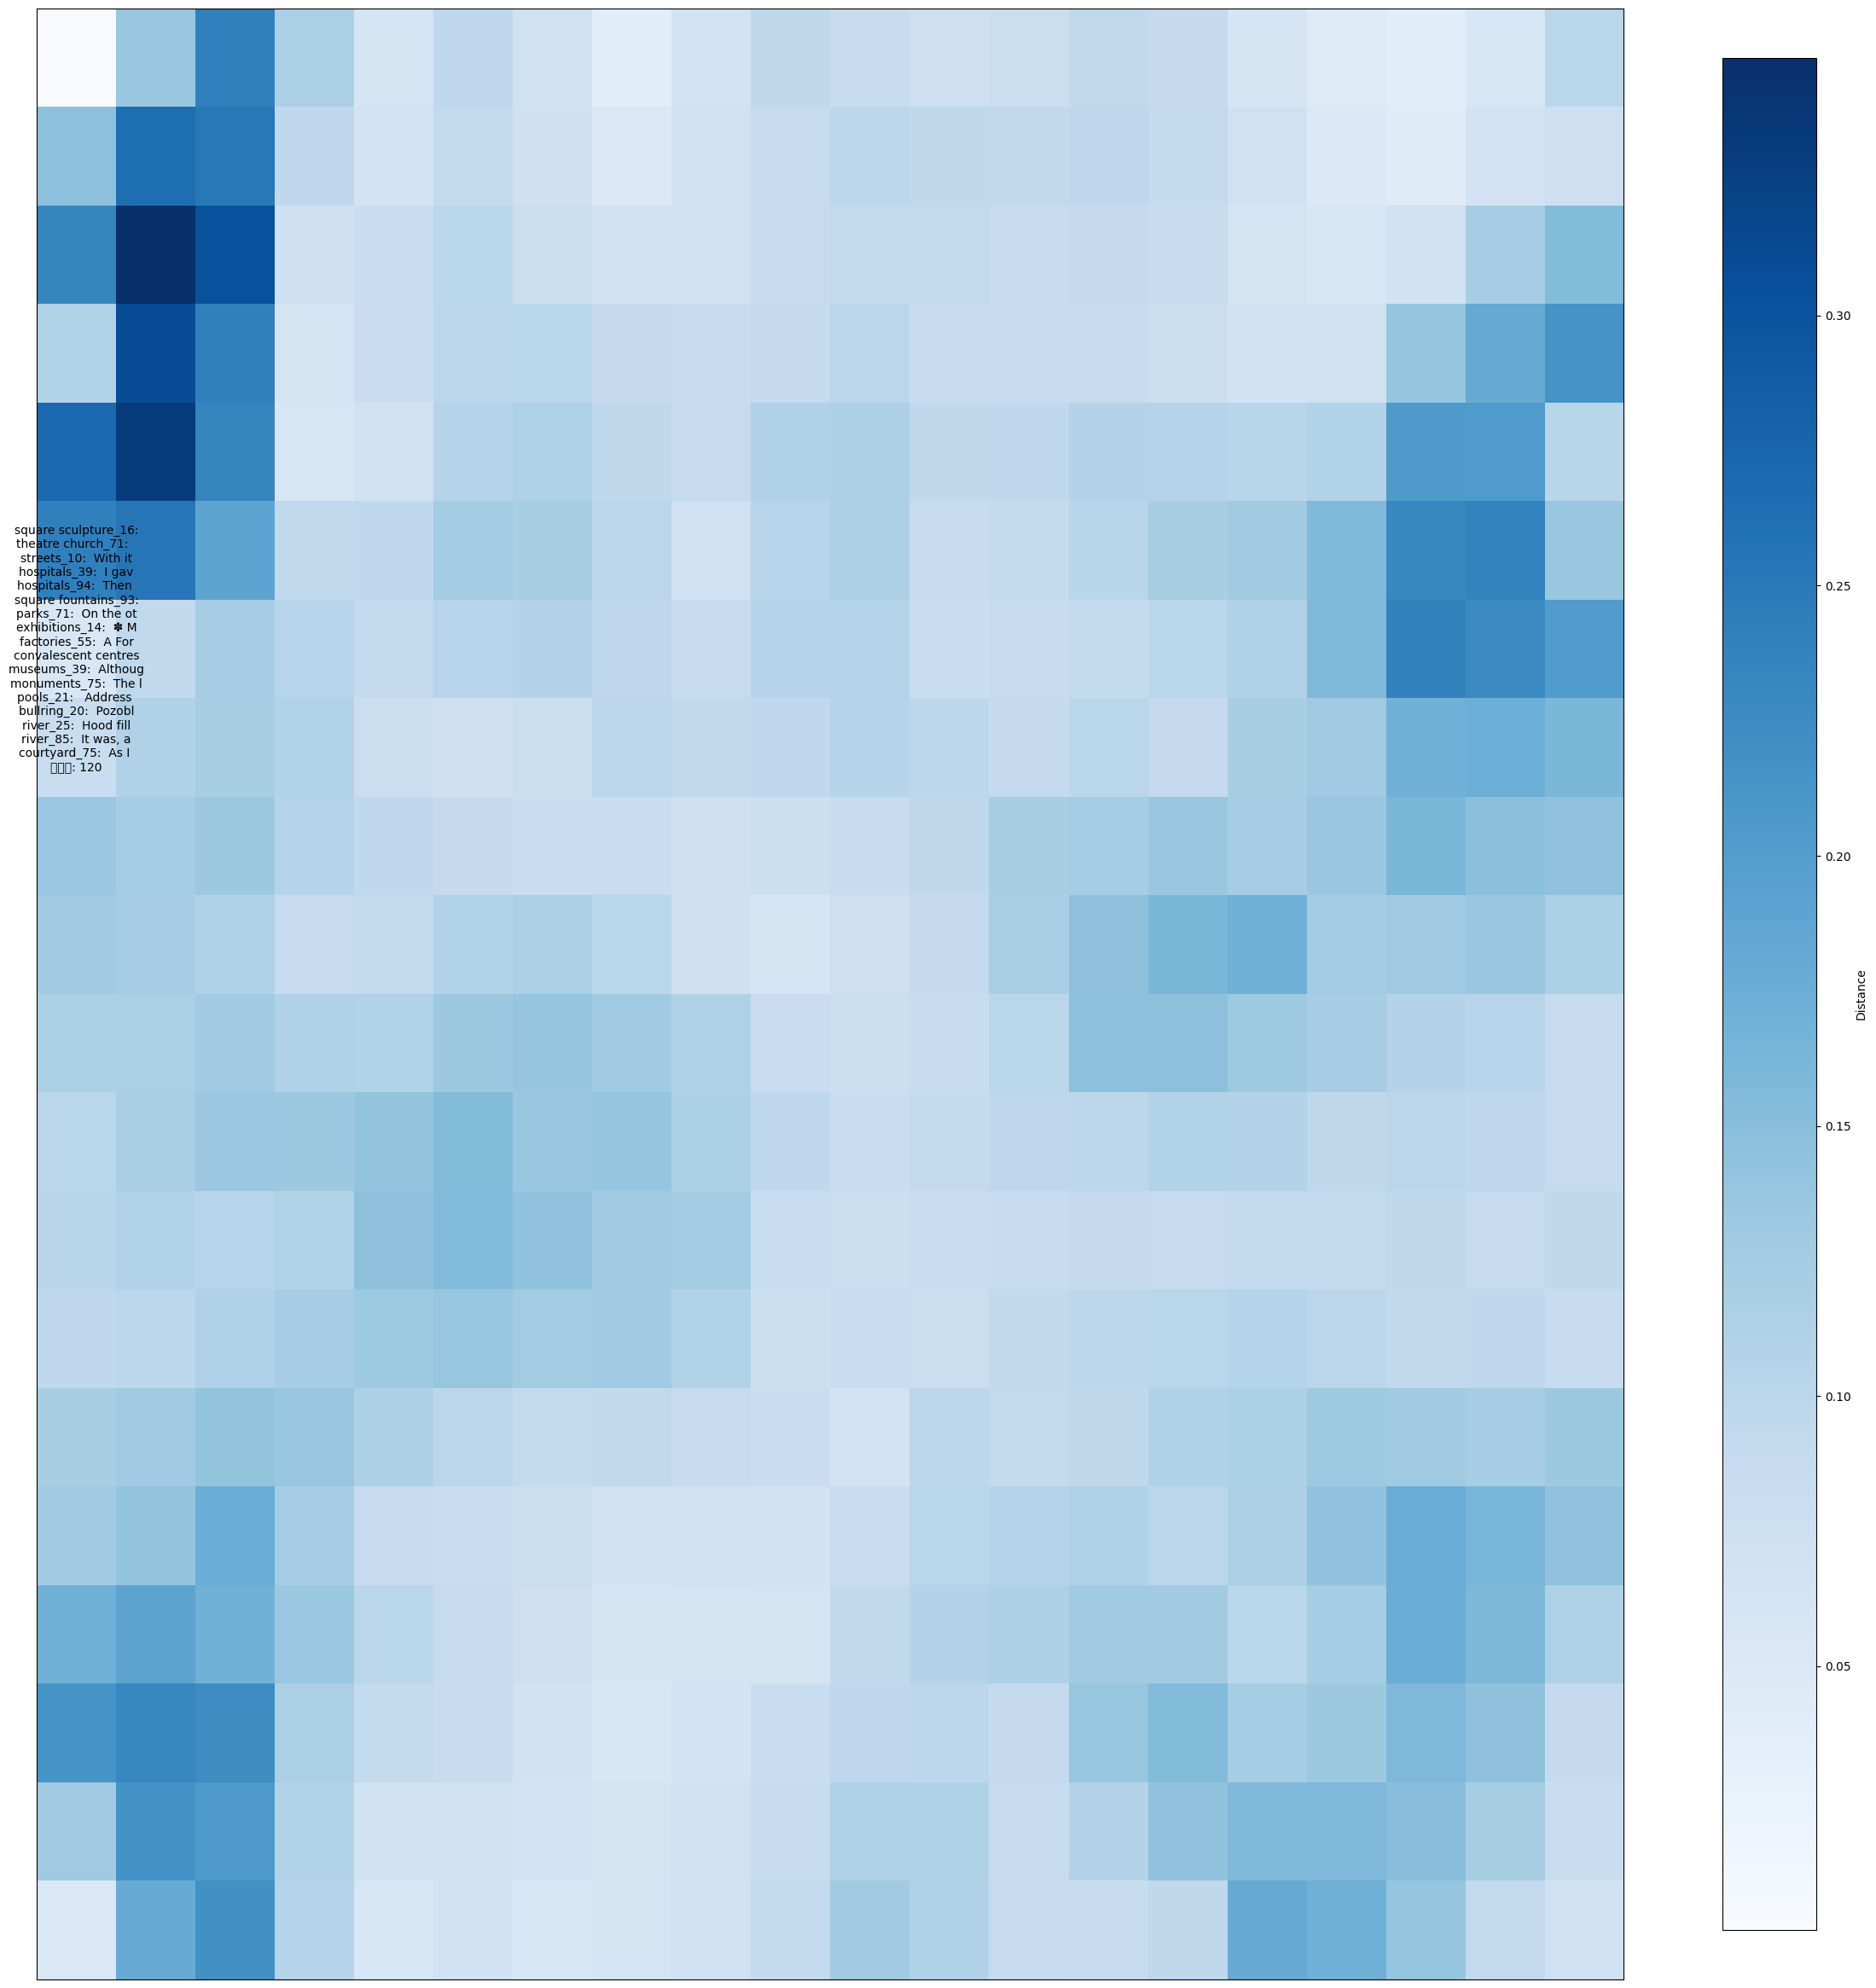

index 1: square sculpture_16:  He was as amazed as Julia. "Squares," he said unhesitatingly. "Black and white squares." He looked up at the Flemish painting, and his voice seemed to tremble. "Like those on a chessboard." Leaving the book open on the sofa, Julia stood up.

index 2: theatre church_71:   Previously known for its home-spun comic theatre (plenty of star names in farcical situations and lots of banging of doors), this comfortable venue has undergone a slight shift of image in recent years. Although the programme now mainly consists of quality drama (most of it 20th century), the theatre also sometimes hosts less high-brow productions, such as Peter Pan. 

index 3: streets_10:  With its streets alive with people, it is, in some ways, a lot better..

index 4: hospitals_39:  I gave her money to pay her bills, for the hospital too, the trip didn’t cost her a penny. No one knew we were together, not even her colleagues, they would have been worried and they would have asked her t

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 假设您有一个变量存储神经元的索引，我们称之为 neuron_indices
neuron_indices = np.arange(len(neuron_word_mapping))

plt.figure(figsize=(30, 30))
im = plt.imshow(u_matrix_values, cmap=cm.Blues, aspect='auto')
plt.colorbar(im, shrink=0.95, label='Distance')

# 选择特定神经元的索引（例如，第19格）
target_neuron_index = 120  # 注意：这是以0为基础的索引
target_neuron_coord = None

for coord, words, neuron_index in zip(neuron_word_mapping.keys(), neuron_word_mapping.values(), neuron_indices):
    # 仅显示目标神经元的文本
    if neuron_index == target_neuron_index:
        target_neuron_coord = coord
        # 仅显示每段文本的前几个字符
        truncated_text = [word[:20] for word in words]
        text = '\n'.join(truncated_text + [f'神经元: {neuron_index}'])
        plt.text(coord[1], coord[0], text, ha='center', va='center', color='black', fontsize=10)  # 增加了 fontsize

plt.xticks([])
plt.yticks([])

# 保存图像到文件
plt.savefig('som_visualization_target_neuron.png', dpi=300)
plt.show()

# 打印目标神经元的所有段落及其序号
if target_neuron_coord is not None:
    for i, paragraph in enumerate(neuron_word_mapping[target_neuron_coord]):
        print(f"index {i + 1}: {paragraph}")
else:
    print(f"未找到神经元 {target_neuron_index}")
